# 单 Workload 时序数据分析

In [1]:
import sys
sys.path.append('./tools')

from aggregation import *
import analyze
import display

pd.set_option('display.max_rows', 20) 

In [2]:
exp_root = "/home/ict/appProfile/data/redis/no_stress/redis_no_20231102130306"
qos_columns = [
    "app_redis_qos_qps_of_redis_get",
    "app_redis_qos_qps_of_redis_total",
    "app_redis_qos_qps_of_redis_set",
    "app_redis_qos_p99_latency_set",
    "app_redis_qos_p99_latency_get",
]

exp_data = read_from_dir(exp_root)
exp_data.set_workload_preprocess_funcs([
    filter_column_startswith(col_prefix=("stress", "vm", "app")),
    filter_column_useless(excol_prefix=("stress")),
    filter_row_noise(col_prefix=("app")),
])

keys = list(exp_data.exp["info_per_epoch"][0]["workloads"].keys())
keys

['redis_0',
 'redis_1',
 'redis_2',
 'redis_3',
 'redis_4',
 'redis_5',
 'redis_6',
 'redis_7',
 'redis_8']

In [3]:
workload_info = exp_data.workloads_of(keys[8])[0]
# 选择QoS指标
qos_column = qos_columns[3]
# 相关性阈值
c = 0.95

df_workload = exp_data.workload_df(workload_info)
df_workload

,vm_hypervisor_emulator_syscall_count_clone3,vm_hypervisor_emulator_syscall_count_fdatasync,vm_hypervisor_emulator_syscall_count_futex_time64,vm_hypervisor_emulator_syscall_count_madvise,vm_hypervisor_emulator_syscall_count_mmap,vm_hypervisor_emulator_syscall_count_mprotect,vm_hypervisor_emulator_syscall_count_munmap,vm_hypervisor_emulator_syscall_count_newfstatat,vm_hypervisor_emulator_syscall_count_poll_time64,vm_hypervisor_emulator_syscall_count_ppoll_time64,...,vm_block_io_bytes_io_write,vm_block_io_requests_write,vm_block_io_time_write,vm_block_io_flush_request_and_time_request_vda,vm_block_io_flush_request_and_time_time_vda,app_redis_qos_qps_of_redis_get,app_redis_qos_qps_of_redis_set,app_redis_qos_qps_of_redis_total,app_redis_qos_p99_latency_set,app_redis_qos_p99_latency_get
Time,,,,,,,,,,,,,,,,,,,,,
1698932422000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.501751,315.657829,18.009005,...,0.0,0.0,0.00000,0.0,0.0,586633.5,58635.0,645268.5,22.414842,22.149509
1698932426000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.501751,315.657829,17.508754,...,0.0,0.0,0.00000,0.0,0.0,574375.0,57445.0,631820.0,21.800782,21.811500
1698932430000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.500000,315.500000,18.500000,...,0.0,0.0,0.00000,0.0,0.0,564590.5,56473.0,621063.5,22.243515,22.234850
1698932434000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.500000,315.500000,18.000000,...,0.0,0.0,0.00000,0.0,0.0,583434.0,58336.5,641770.5,22.038489,22.053615
1698932438000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.498251,315.342329,16.991504,...,0.0,0.0,0.00000,0.0,0.0,549086.0,54870.5,603956.5,22.763341,22.770995
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1698932562000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.501751,315.657829,18.009005,...,0.0,0.0,0.00000,0.0,0.0,582582.5,58288.5,640871.0,21.900505,21.900467
1698932566000,1.0,0.0,0.5,0.5,0.0,0.0,0.0,3.500000,315.500000,19.500000,...,2048.0,0.5,0.00025,0.0,0.0,581209.0,58149.0,639358.0,21.757188,21.757719
1698932570000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.500000,315.500000,17.000000,...,0.0,0.0,0.00000,0.0,0.0,573636.0,57247.5,630883.5,22.323959,22.357965


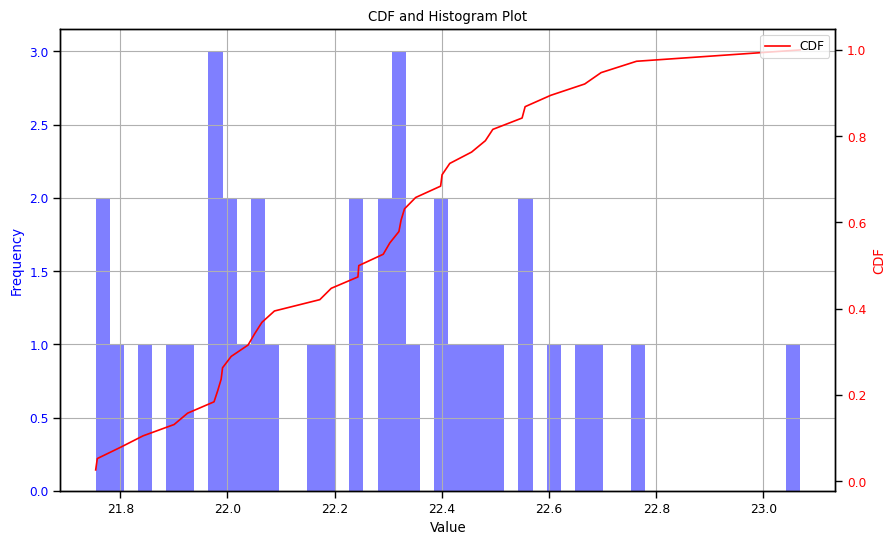

In [4]:
import numpy as np
import matplotlib.pyplot as plt
data_series = df_workload[qos_column]

# 计算CDF
sorted_data = np.sort(data_series)
cdf = np.arange(1, len(sorted_data) + 1) / float(len(sorted_data))

# 计算CDF
sorted_data = np.sort(data_series)
cdf = np.arange(1, len(sorted_data) + 1) / float(len(sorted_data))

# 绘制CDF和直方图
fig, ax1 = plt.subplots(figsize=(10, 6))

# 左y轴绘制直方图
ax1.hist(sorted_data, bins=50, density=True, alpha=0.5, color='b', label='Histogram')
ax1.set_xlabel('p99 Latency')
ax1.set_ylabel('Fraction of Time', color='b')
ax1.tick_params(axis='y', labelcolor='b')
ax1.grid(True)

# 使用twinx()创建右y轴，绘制CDF
ax2 = ax1.twinx()
ax2.plot(sorted_data, cdf, color='r', label='CDF')
ax2.set_ylabel('CDF', color='r')
ax2.tick_params(axis='y', labelcolor='r')
ax2.legend(loc='upper right')

plt.show()

# 一、相关性分析

## (1) 皮尔逊相关性

In [ ]:
pearson_corr_matrix = analyze.pearson_correlation(df_workload)
pearson_corr_matrix

In [ ]:
display.plt_corr_heatmap(pearson_corr_matrix)

### 1. 相关性排序

In [ ]:
flat_corr_df = analyze.flatten_corr(
    pearson_corr_matrix,
    similarity_filter = [
        lambda x: x[x.abs() > c].dropna(axis=0, how='all'),
])
flat_corr_df

### 2. QoS 相关指标

In [ ]:
qos_corr = analyze.single_corr(pearson_corr_matrix, qos_column, similarity_filter = [
    lambda x: x[x.abs() > c].dropna(axis=0, how='all'),
])
qos_corr

In [ ]:
columns = list(qos_corr.index)[:16]
display.plt_by_column(df_workload, x_column=qos_column, columns=columns)

### 3. 相关性最大团

In [ ]:
G, cliques = analyze.cliques_from_corr(pearson_corr_matrix, threshold=0.99)
largest_clique = cliques[0]
largest_clique

In [ ]:
display.plt_clique_on_graph(G, largest_clique, scaling=1.25, label_pos=0.35)

## (2) 余弦相似性

In [ ]:
cos_similarity_matrix = analyze.cosine_similarity(df_workload)
cos_similarity_matrix

In [ ]:
display.plt_corr_heatmap(cos_similarity_matrix)

### 1. 相似性排序

In [ ]:
flat_corr_df = analyze.flatten_corr(cos_similarity_matrix, similarity_filter = [
    lambda x: x[x > c].dropna(axis=0, how='all'),
])
flat_corr_df

### 2. QoS 相似指标

In [ ]:
qos_corr = analyze.single_corr(cos_similarity_matrix, qos_column, similarity_filter = [
    lambda x : x[x.abs() > c].dropna(axis=0, how='all'),
    lambda x : x.drop(qos_columns, errors='ignore'),
])
qos_corr

In [ ]:
display.plt_by_column(df_workload, x_column=qos_column, columns=list(qos_corr.index), ncols=3)

### 3. 相似性最大团

In [ ]:
G, cliques = analyze.cliques_from_corr(cos_similarity_matrix, threshold=0.99)
largest_clique = cliques[0]
largest_clique

In [ ]:
display.plt_clique_on_graph(G, largest_clique, scaling=1.25, label_pos=0.35)